In [47]:
# Import dependencies
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


In [20]:
# Open the connection to the persistent database
con = duckdb.connect(".config/nfl.duckdb")
#con.close()

In [21]:
# Create the initial dataframe object with DuckDB
df = con.sql("""
    SELECT *
    FROM gold.plays_numeric             
""").df()

df.head()

,gameId,playId,possessionTeam,yardlineNumber,offenseFormation,receiverAlignment,playType,defensiveFormation,pff_manZone,yardsGained,playOutcome
0,2022102302,2655,CIN,21,3,8,2,6,2,9,3
1,2022091809,3698,CIN,8,3,8,2,13,2,4,3
2,2022103004,3146,HOU,20,6,5,2,13,2,6,3
3,2022110610,348,KC,23,6,5,2,13,2,4,3
4,2022102700,2799,BAL,27,4,7,1,3,1,-1,2


In [23]:
# Split the table into features and target
X = con.sql("""
    SELECT yardlineNumber, offenseFormation, receiverAlignment, playType, defensiveFormation, pff_manZone
    FROM gold.plays_numeric
""").df()

y = np.array(con.sql("""
    SELECT playOutcome
    FROM gold.plays_numeric
""").df()).ravel()

print(X.shape, y.shape)

(16124, 6) (16124,)


In [29]:
# Instantiate the model and split the datasets into training/testing
knn = KNeighborsClassifier(n_neighbors=7)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=123)

In [30]:
# Fit the model
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [31]:
# Basic KNN Performance Metrics
y_pred = knn.predict(X_val)

print(knn.score(X_val, y_val))

0.6114096734187681


In [27]:
# Datacamp Model performance Loop
# Create neighbors
neighbors = np.arange(1, 13)
train_accuracies = {}
test_accuracies = {}

for neighbor in neighbors:
  
	# Set up a KNN Classifier
	knn = KNeighborsClassifier(n_neighbors=neighbor)
  
	# Fit the model
	knn.fit(X_train, y_train)
  
	# Compute accuracy
	train_accuracies[neighbor] = knn.score(X_train, y_train)
	test_accuracies[neighbor] = knn.score(X_val, y_val)
print(neighbors, '\n', train_accuracies, '\n', test_accuracies)

[ 1  2  3  4  5  6  7  8  9 10 11 12] 
 {np.int64(1): 0.703083466241361, np.int64(2): 0.6805777068934964, np.int64(3): 0.6860712387028176, np.int64(4): 0.6831472620946305, np.int64(5): 0.6813751550593656, np.int64(6): 0.6811979443558391, np.int64(7): 0.6776537302853093, np.int64(8): 0.6735778841041999, np.int64(9): 0.6710083289030657, np.int64(10): 0.6704766967924862, np.int64(11): 0.6669324827219564, np.int64(12): 0.6640971114655325} 
 {np.int64(1): 0.5210830921868541, np.int64(2): 0.555601488218272, np.int64(3): 0.5673832162050434, np.int64(4): 0.5859859446052088, np.int64(5): 0.5975609756097561, np.int64(6): 0.6016949152542372, np.int64(7): 0.6114096734187681, np.int64(8): 0.6066556428276147, np.int64(9): 0.6058288548987185, np.int64(10): 0.6062422488631666, np.int64(11): 0.6066556428276147, np.int64(12): 0.6081025217031831}


In [ ]:
# Visualize model accuracy with various neighbors
# Add a title
plt.title("KNN: Varying Number of Neighbors")

# Plot training accuracies
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")

# Plot test accuracies
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")

# Display the plot
plt.show()

In [77]:
# Map the original target variables to the KNN outputs
play_outcome_map = con.sql("""
    SELECT
    CASE
        WHEN playOutcome = 1 THEN 'Gain'
        WHEN playOutcome = 2 THEN 'Loss'
        WHEN playOutcome = 3 THEN 'Completed'
        WHEN playOutcome = 4 THEN 'Incomplete'
        WHEN playOutcome = 5 THEN 'Scrambled'
        WHEN playOutcome = 6 THEN 'Touchdown'
        WHEN playOutcome = 7 THEN 'Intercepted'
        WHEN playOutcome = 8 THEN 'Fumbled'
        WHEN playOutcome = 9 THEN 'Sacked'
        WHEN playOutcome = 0 THEN 'Penalty'
        ELSE 'Unknown'  -- Optional, in case there are values not matching any condition
    END AS playOutcome
FROM gold.plays_numeric
""").df()['playOutcome'].tolist()

play_outcome_map = np.unique(play_outcome_map).tolist()

In [78]:
# Create a dictionary to map playOutcome values to corresponding labels
play_outcome_dict = {i: play_outcome_map[i] for i in range(len(play_outcome_map))}

# Generate a colormap for the string labels (use 'viridis' colormap)
colors = plt.cm.viridis(np.linspace(0, 1, len(play_outcome_map)))
play_colors = dict(zip(range(len(play_outcome_map)), colors))

# Create legend patches for each class label
legend_patches = [mpatches.Patch(color=play_colors[i], label=play_outcome_map[i]) for i in range(len(play_outcome_map))]

# Assuming `y_pred` is a list of predictions, map numeric predictions to string labels
pred_labels = [play_outcome_dict[val] for val in y_pred]


/var/folders/b6/v_rmb82s4yv51n0y4g30nxt80000gn/T/ipykernel_53208/2628070696.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_val.iloc[:, feature], y_pred, c=[play_colors[val] for val in y_pred], cmap='viridis', edgecolor='k')


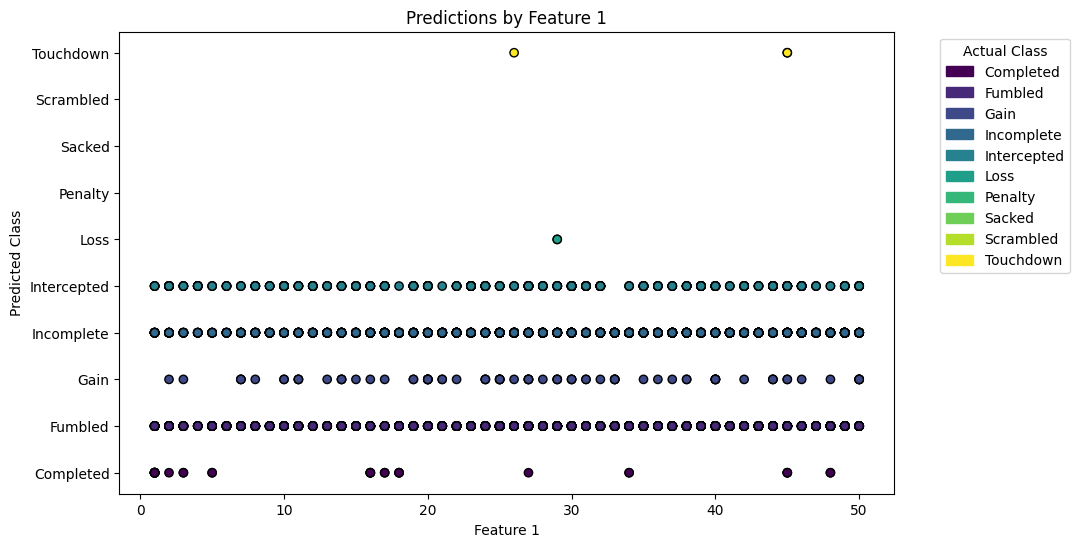

/var/folders/b6/v_rmb82s4yv51n0y4g30nxt80000gn/T/ipykernel_53208/2628070696.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_val.iloc[:, feature], y_pred, c=[play_colors[val] for val in y_pred], cmap='viridis', edgecolor='k')


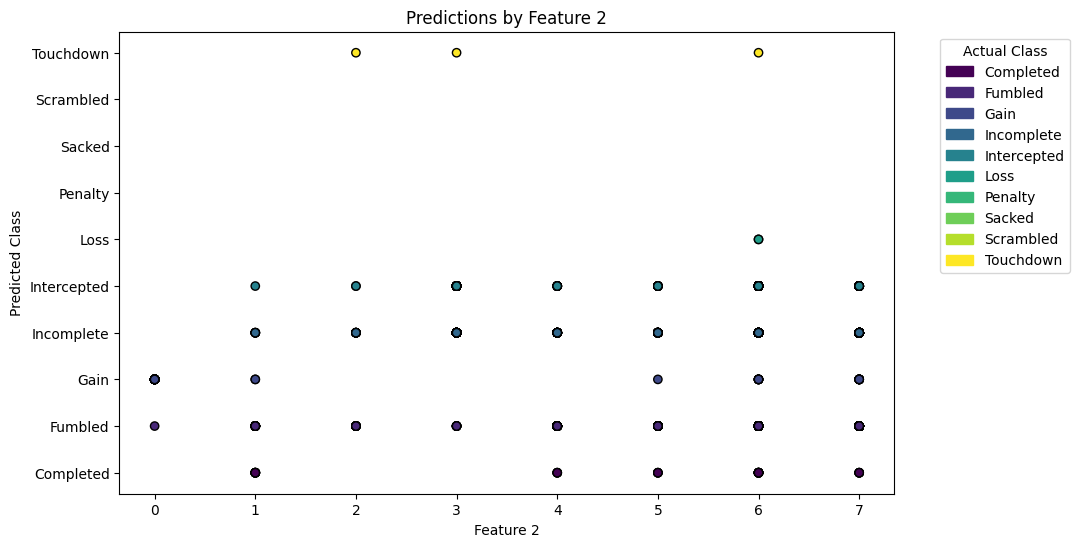

/var/folders/b6/v_rmb82s4yv51n0y4g30nxt80000gn/T/ipykernel_53208/2628070696.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_val.iloc[:, feature], y_pred, c=[play_colors[val] for val in y_pred], cmap='viridis', edgecolor='k')


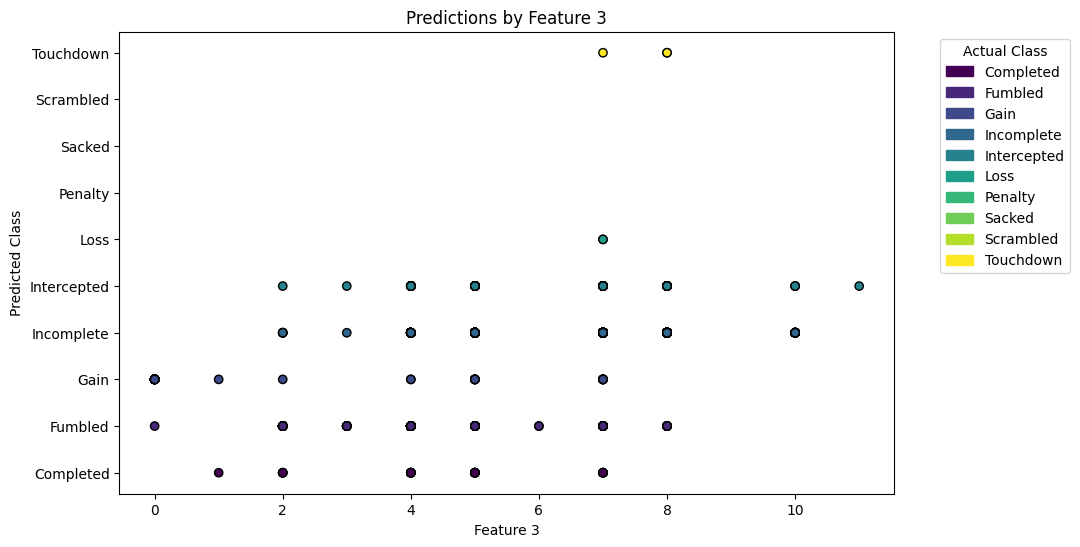

/var/folders/b6/v_rmb82s4yv51n0y4g30nxt80000gn/T/ipykernel_53208/2628070696.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_val.iloc[:, feature], y_pred, c=[play_colors[val] for val in y_pred], cmap='viridis', edgecolor='k')


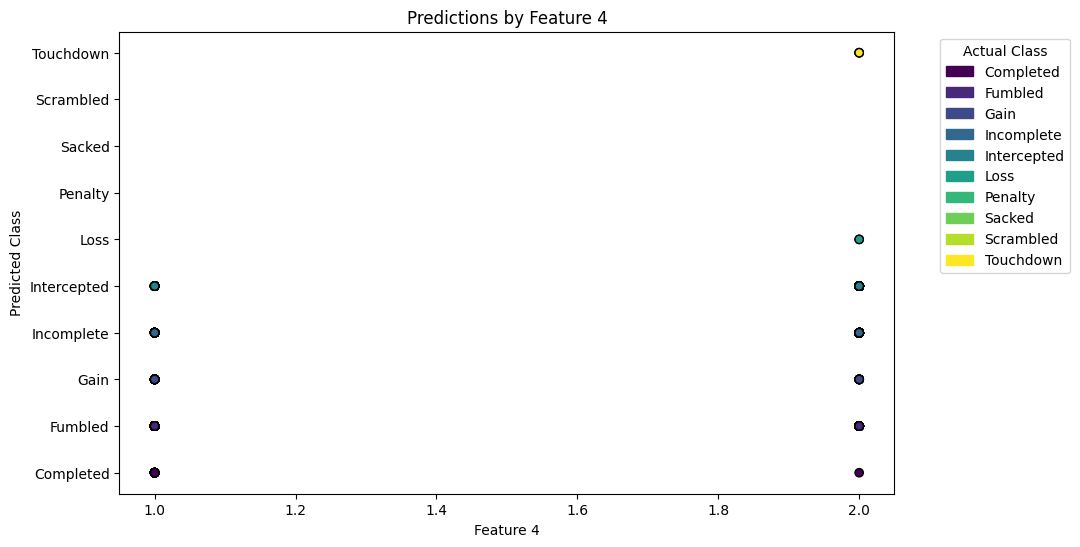

/var/folders/b6/v_rmb82s4yv51n0y4g30nxt80000gn/T/ipykernel_53208/2628070696.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_val.iloc[:, feature], y_pred, c=[play_colors[val] for val in y_pred], cmap='viridis', edgecolor='k')


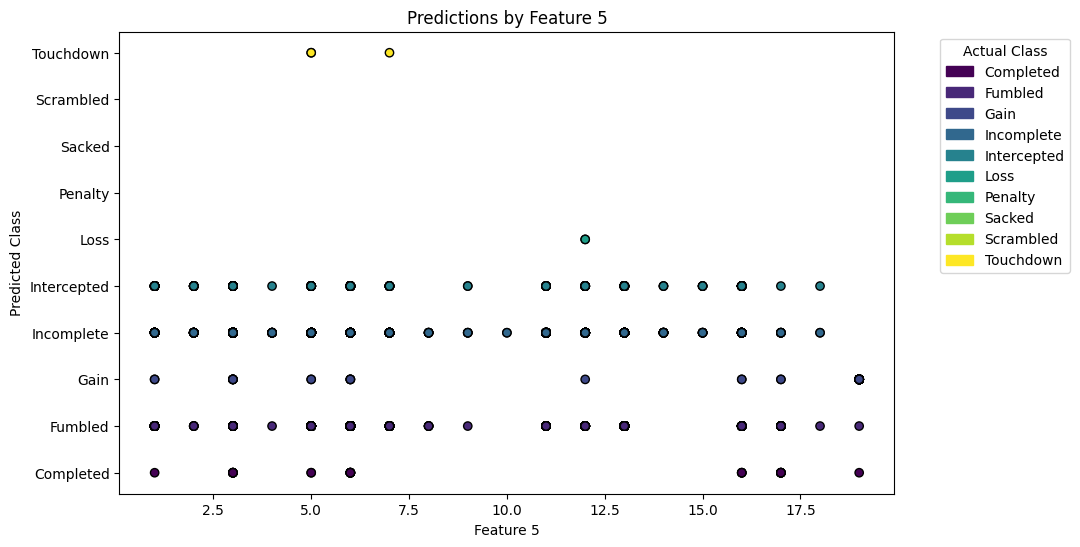

/var/folders/b6/v_rmb82s4yv51n0y4g30nxt80000gn/T/ipykernel_53208/2628070696.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_val.iloc[:, feature], y_pred, c=[play_colors[val] for val in y_pred], cmap='viridis', edgecolor='k')


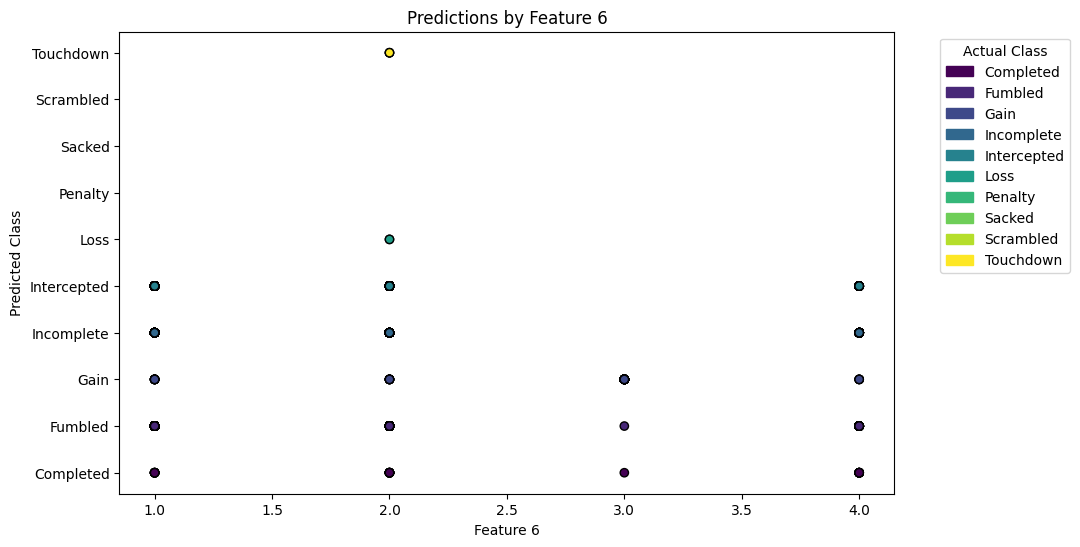

In [83]:
# Attempting to conduct sensitivity analysis for feature importance
for feature in range(6):
    plt.figure(figsize=(10, 6))
    plt.scatter(X_val.iloc[:, feature], y_pred, c=[play_colors[val] for val in y_pred], cmap='viridis', edgecolor='k')
    plt.xlabel(f"Feature {feature + 1}")
    plt.ylabel("Predicted Class")
    plt.yticks(range(len(play_outcome_map)), play_outcome_map)
    plt.title(f"Predictions by Feature {feature + 1}")
    plt.legend(handles = legend_patches, title="Actual Class", bbox_to_anchor=(1.05, 1), loc = 'upper left')
    plt.tight_layout
    plt.show()
